In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# inspired by exercises 8
from abc import abstractmethod, ABC
import os

import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from IPython.display import clear_output
#from backbones.fcnet import FCNet
from fcnet import FCNet

import matplotlib.pyplot as plt

import pickle


In [45]:
from datasets.prot.utils import get_samples_using_ic, check_min_samples, get_mode_ids, encodings, get_ids

In [46]:
class MetaTemplate(nn.Module):
    def __init__(self, backbone, n_way, n_support):
        super(MetaTemplate, self).__init__()
        self.n_way = n_way
        self.n_support = n_support
        self.n_query = -1  # (change depends on input)
        self.feature = backbone
        self.feat_dim = self.feature.final_feat_dim

        # n_way = nb_classes per episode
        # n_support = nb_samples per class for support set
        # n_query = nb_samples per class for query set
        # backbone = feature extractor (embedding network) ie. function f

        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

    @abstractmethod
    def set_forward(self, x, is_feature=False):
        """
        forward pass, returns score (probabilities for query set)
        output is logits for all query set (prob of each class)
        first dim of output is n_way * n_query, nb of samples in query set
        second dim is prob to belong to each class
        x: [n_way, n_support + n_query, **embedding_dim]
        out: [n_way * n_query, n_way]
        """
        pass

    @abstractmethod
    def set_forward_loss(self, x):
        """
        takes the episode and compute loss of episode
        x: [n_way, n_support + n_query, **embedding_dim]
        out: loss (scalar)
        """
        
        pass

    def forward(self, x):
        out = self.feature.forward(x)
        return out

    def parse_feature(self, x, is_feature):
        if isinstance(x, list):
            x = [Variable(obj.to(self.device)) for obj in x]
        else: x = Variable(x.to(self.device))
        if is_feature:
            z_all = x
        else:
            if isinstance(x, list):
                x = [obj.contiguous().view(self.n_way * (self.n_support + self.n_query), *obj.size()[2:]) for obj in x]
            else: x = x.contiguous().view(self.n_way * (self.n_support + self.n_query), *x.size()[2:])
            z_all = self.feature.forward(x)
            z_all = z_all.view(self.n_way, self.n_support + self.n_query, -1)
        z_support = z_all[:, :self.n_support]
        z_query = z_all[:, self.n_support:]

        return z_support, z_query

    def correct(self, x):
        # Compute the predictions scores.
        scores = self.set_forward(x)

        # Compute the top1 elements.
        topk_scores, topk_labels = scores.data.topk(k=1, dim=1, largest=True, sorted=True)

        # Detach the variables (transforming to numpy also detach the tensor)
        topk_ind = topk_labels.cpu().numpy()

        # Create the category labels for the queries, this is unique for the few shot learning setup
        y_query = np.repeat(range(self.n_way), self.n_query)

        #>>> np.repeat(range(10), 2)
        #array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9])

        # Compute number of elements that are correctly classified.
        top1_correct = np.sum(topk_ind[:, 0] == y_query)
        return float(top1_correct), len(y_query)

    def train_loop(self, epoch, train_loader, optimizer):
        print_freq = 10

        avg_loss = 0
        for i, (x, _) in enumerate(train_loader):
            self.n_query = x.size(1) - self.n_support
            optimizer.zero_grad()
            loss = self.set_forward_loss(x)
            loss.backward()
            optimizer.step()
            avg_loss = avg_loss + loss.item()

            if i % print_freq == 0:
                print('Epoch {:d} | Batch {:d}/{:d} | Loss {:f}'.format(epoch, i, len(train_loader),
                                                                        avg_loss / float(i + 1)))
        return avg_loss/len(train_loader)
    
    def test_loop(self, test_loader, record=None, return_std=False):
        correct = 0
        count = 0
        acc_all = []

        iter_num = len(test_loader)
        for i, (x, _) in enumerate(test_loader):
            if isinstance(x, list):
                self.n_query = x[0].size(1) - self.n_support
                if self.change_way:
                    self.n_way = x[0].size(0)
            else: 
                self.n_query = x.size(1) - self.n_support
                if self.change_way:
                    self.n_way = x.size(0)
            correct_this, count_this = self.correct(x)
            acc_all.append(correct_this / count_this * 100)

        acc_all = np.asarray(acc_all)
        acc_mean = np.mean(acc_all)
        acc_std = np.std(acc_all)
        print('%d Test Acc = %4.2f%% +- %4.2f%%' % (iter_num, acc_mean, 1.96 * acc_std / np.sqrt(iter_num)))

        if return_std:
            return acc_mean, acc_std
        else:
            return acc_mean


In [47]:
class MetaTemplate(nn.Module):
    def __init__(self, backbone, n_way, n_support, change_way=True):
        super(MetaTemplate, self).__init__()
        self.n_way = n_way
        self.n_support = n_support
        self.n_query = -1  # (change depends on input)
        self.feature = backbone
        self.feat_dim = self.feature.final_feat_dim
        self.change_way = change_way  # some methods allow different_way classification during training and test

        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

    @abstractmethod
    def set_forward(self, x, is_feature=False):
        pass

    @abstractmethod
    def set_forward_loss(self, x):
        pass

    def forward(self, x):
        out = self.feature.forward(x)
        return out

    def parse_feature(self, x, is_feature):
        if isinstance(x, list):
            x = [Variable(obj.to(self.device)) for obj in x]
        else: x = Variable(x.to(self.device))
        if is_feature:
            z_all = x
        else:
            if isinstance(x, list):
                x = [obj.contiguous().view(self.n_way * (self.n_support + self.n_query), *obj.size()[2:]) for obj in x]
            else: x = x.contiguous().view(self.n_way * (self.n_support + self.n_query), *x.size()[2:])
            z_all = self.feature.forward(x)
            z_all = z_all.view(self.n_way, self.n_support + self.n_query, -1)
        z_support = z_all[:, :self.n_support]
        z_query = z_all[:, self.n_support:]

        return z_support, z_query

    def correct(self, x):
        scores = self.set_forward(x)
        y_query = np.repeat(range(self.n_way), self.n_query)

        topk_scores, topk_labels = scores.data.topk(1, 1, True, True)
        topk_ind = topk_labels.cpu().numpy()
        top1_correct = np.sum(topk_ind[:, 0] == y_query)
        return float(top1_correct), len(y_query)

    def correlation(self, x, y, type="pearson"):
        y_pred = self.set_forward(x, y).reshape(-1).to(self.device)
        y_query = y[:, self.n_support:].reshape(-1).to(self.device)

        if type == "pearson":
            # corr = pearsonr(y_pred, y_query)
            corr = pearson_corr(y_pred, y_query)
        else:
            # Raise an error, this type is not defined
            raise ValueError(f"Correlation type {type} not defined")

        return corr.cpu().detach().numpy()

    def train_loop(self, epoch, train_loader, optimizer):
        print_freq = 10

        avg_loss = 0
        for i, (x, _) in enumerate(train_loader):
            if isinstance(x, list):
                self.n_query = x[0].size(1) - self.n_support
                if self.change_way:
                    self.n_way = x[0].size(0)
            else: 
                self.n_query = x.size(1) - self.n_support
                if self.change_way:
                    self.n_way = x.size(0)
            optimizer.zero_grad()
            loss = self.set_forward_loss(x)
            loss.backward()
            optimizer.step()
            avg_loss = avg_loss + loss.item()

            if i % print_freq == 0:
                # print(optimizer.state_dict()['param_groups'][0]['lr'])
                print('Epoch {:d} | Batch {:d}/{:d} | Loss {:f}'.format(epoch, i, len(train_loader),
                                                                        avg_loss / float(i + 1)))
                #wandb.log({"loss": avg_loss / float(i + 1)})

    def test_loop(self, test_loader, record=None, return_std=False):
        correct = 0
        count = 0
        acc_all = []

        iter_num = len(test_loader)
        for i, (x, _) in enumerate(test_loader):
            if isinstance(x, list):
                self.n_query = x[0].size(1) - self.n_support
                if self.change_way:
                    self.n_way = x[0].size(0)
            else: 
                self.n_query = x.size(1) - self.n_support
                if self.change_way:
                    self.n_way = x.size(0)
            correct_this, count_this = self.correct(x)
            acc_all.append(correct_this / count_this * 100)

        acc_all = np.asarray(acc_all)
        acc_mean = np.mean(acc_all)
        acc_std = np.std(acc_all)
        print('%d Test Acc = %4.2f%% +- %4.2f%%' % (iter_num, acc_mean, 1.96 * acc_std / np.sqrt(iter_num)))

        if return_std:
            return acc_mean, acc_std
        else:
            return acc_mean


    def set_forward_adaptation(self, x,
                               is_feature=True):  # further adaptation, default is fixing feature and train a new softmax clasifier
        assert is_feature == True, 'Feature is fixed in further adaptation'
        z_support, z_query = self.parse_feature(x, is_feature)

        z_support = z_support.contiguous().view(self.n_way * self.n_support, -1)
        z_query = z_query.contiguous().view(self.n_way * self.n_query, -1)

        y_support = torch.from_numpy(np.repeat(range(self.n_way), self.n_support))
        y_support = Variable(y_support.cuda())

        linear_clf = nn.Linear(self.feat_dim, self.n_way)
        linear_clf = linear_clf.cuda()

        set_optimizer = torch.optim.SGD(linear_clf.parameters(), lr=0.01, momentum=0.9, dampening=0.9,
                                        weight_decay=0.001)

        loss_function = nn.CrossEntropyLoss()
        loss_function = loss_function.cuda()

        batch_size = 4
        support_size = self.n_way * self.n_support
        for epoch in range(100):
            rand_id = np.random.permutation(support_size)
            for i in range(0, support_size, batch_size):
                set_optimizer.zero_grad()
                selected_id = torch.from_numpy(rand_id[i: min(i + batch_size, support_size)]).cuda()
                z_batch = z_support[selected_id]
                y_batch = y_support[selected_id]
                scores = linear_clf(z_batch)
                loss = loss_function(scores, y_batch)
                loss.backward()
                set_optimizer.step()

        scores = linear_clf(z_query)
        return scores


# ProtoNet

In [48]:
class ProtoNet(MetaTemplate):
    def __init__(self, backbone, n_way, n_support):
        super(ProtoNet, self).__init__(backbone, n_way, n_support)
        self.loss_fn = nn.CrossEntropyLoss()

    def set_forward(self, x):
        # Compute the prototypes (support) and queries (embeddings) for each datapoint.
        # Remember that you implemented a function to compute this before.
        z_support, z_query = self.parse_feature(x)
            
        # Compute the prototype.
        z_support = z_support.contiguous().view(self.n_way, self.n_support, -1)
        z_proto = z_support.mean(dim=1)
        
        # Format the queries for the similarity computation.
        z_query = z_query.contiguous().view(self.n_way * self.n_query, -1)

        # Compute similarity score based on the euclidean distance between prototypes and queries.
        scores = -euclidean_dist(z_query, z_proto)

        return scores

    def set_forward_loss(self, x):
        # Compute the similarity scores between the prototypes and the queries.
        scores = self.set_forward(x)
        
        # Create the category labels for the queries.
        y_query = torch.from_numpy(np.repeat(range(self.n_way), self.n_query))
        y_query = Variable(y_query).to(self.device)

        # Compute the loss
        loss = self.loss_fn(scores, y_query)
        return loss

def euclidean_dist( x, y):
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

In [49]:
class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs, targets): # inputs: torch.Size([75, 59, 64]), targets: torch.Size([75])
        inputs = inputs.view(inputs.size(0), inputs.size(1), -1)
        # inputs: torch.Size([75, 59, 64])
        log_probs = self.logsoftmax(inputs)

        # below = problematic line
        # torch zeros (75, 59)
        targets = torch.zeros(inputs.size(0), inputs.size(1)).scatter_(1, targets.unsqueeze(1).data.cpu(), 1)
        targets = targets.unsqueeze(-1)
        targets = targets.cuda()
        loss = (- targets * log_probs).mean(0).sum() 
        return loss / inputs.size(2)

# CanNet

In [50]:
class CanNet(MetaTemplate):
    def __init__(self, backbone, n_way, n_support, reduction_ratio=6, temperature=0.025, scale_cls=7, num_classes=7195):
        super(CanNet, self).__init__(backbone, n_way, n_support)
        self.loss_fn = nn.CrossEntropyLoss()
        self.m = self.feat_dim
        self.num_classes = num_classes
        #self.linear = nn.Linear(self.m, n_way)
        #self.linear = nn.Linear(self.m, self.num_classes)
        self.linear = nn.Linear(1, self.num_classes)
        self.fusion_conv = nn.Conv1d(self.feat_dim, 1, kernel_size=1)
        self.bn = nn.BatchNorm1d(int(self.feat_dim / reduction_ratio))
        self.w1 = nn.Linear(self.m, int(self.m / reduction_ratio))
        self.activation = nn.ReLU()
        self.w2 = nn.Linear(int(self.m / reduction_ratio), self.m)
        self.softmax = nn.Softmax(dim=-1)
        self.temperature = temperature
        self.scale_cls = scale_cls
        self.weight_factor = 0.5
        self.cosine_distance = nn.CosineSimilarity(dim=2, eps=1e-6)

    def set_forward(self, x, is_feature=False):
        # Compute the prototypes (support) and queries (embeddings) for each datapoint.
        z_support, z_query = self.parse_feature(x, is_feature)
            
        # Compute the prototype.
        z_support = z_support.contiguous().view(self.n_way, self.n_support, -1)
        z_proto = z_support.mean(dim=1)
        
        # Format the queries for the similarity computation.
        z_query = z_query.contiguous().view(self.n_way * self.n_query, -1)
        z_proto_attention, z_query_attention = self.cross_attention_module(z_proto, z_query)
        
        # ftest is used for the global classification loss, the second loss
        ftest = z_query_attention
        
        # z_proto_attention: torch.Size([5, 75, 64]) ie. [n_way, n_query, feat_dim]
        # z_query_attention: torch.Size([5, 75, 64]) ie. [n_way, n_query, feat_dim]
        z_proto_attention_mean = z_proto_attention.mean(dim=1) # torch.Size([5, 64])
        z_query_attention_mean = z_query_attention.mean(dim=0) # torch.Size([75, 64])

        # Compute similarity score based on the euclidean distance between prototypes and queries.
        #scores = -euclidean_dist(z_query, z_proto)
        scores = -euclidean_dist(z_query_attention_mean, z_proto_attention_mean)

        # use cosine similarity instead of euclidean distance for the scores
        #score_cosine = self.cosine_distance(z_query_attention_mean.unsqueeze(1), z_proto_attention_mean.unsqueeze(0))
        #scores = score_cosine

        return scores, ftest

    def set_forward_loss(self, x, y_true_query):
        # Compute the similarity scores between the prototypes and the queries.
        scores, ftest = self.set_forward(x)
        
        # Create the category labels for the queries.
        y_query = torch.from_numpy(np.repeat(range(self.n_way), self.n_query))
        y_query = Variable(y_query).to(self.device)

        # Compute the knn loss (base protonet loss)
        l1 = self.loss_fn(scores, y_query)

        # Compute the global classification loss

        def one_hot(labels_train):
            """
            Turn the labels_train to one-hot encoding.
            Args:
                labels_train: [batch_size, num_train_examples]
            Return:
                labels_train_1hot: [batch_size, num_train_examples, K]
            """
            labels_train = labels_train.cpu()
            nKnovel = 1 + labels_train.max()
            labels_train_1hot_size = list(labels_train.size()) + [nKnovel,]
            labels_train_unsqueeze = labels_train.unsqueeze(dim=labels_train.dim())
            labels_train_1hot = torch.zeros(labels_train_1hot_size).scatter_(len(labels_train_1hot_size) - 1, labels_train_unsqueeze, 1)
            return labels_train_1hot

        y_query_one_hot = one_hot(y_query).cuda()
        # ftest is of shape (5, 75, 64), change it to (1, 75, 64, 5) to be able to do matmul
        ftest = ftest.unsqueeze(0) # torch.Size([1, 5, 75, 64])
        ftest = ftest.transpose(2, 3) # torch.Size([1, 5, 64, 75])
        ftest = ftest.transpose(1, 3) # torch.Size([1, 75, 64, 5])
        
        # this matmul is incorrect should be ftest: (1, 75, 64, 5) and y_query_one_hot: (1, 75, 5, 1)
        y_query_one_hot = y_query_one_hot.unsqueeze(0) # torch.Size([1, 5, 75, 5])
        y_query_one_hot = y_query_one_hot.unsqueeze(3) # torch.Size([1, 5, 75, 5, 1])
        ftest = torch.matmul(ftest, y_query_one_hot) # torch.Size([1, 75, 64, 1])
        ftest = ftest.view(-1, self.m) # torch.Size([75, 64])

        ftest = ftest.unsqueeze(2) # torch.Size([75, 64, 1])

        ytest = self.linear(ftest) # torch.Size([75, 64, 59])
        ytest = ytest.transpose(2, 1) # torch.Size([75, 59, 64])
        y_true_query = y_true_query.reshape(-1) #torch.Size([75])

        # special loss used in the paper
        criterion = CrossEntropyLoss()

        # compute the global classification loss
        l2 = criterion(ytest, y_true_query)
        loss = self.weight_factor * l1 + l2

        return loss
    def fusion_layer(self, z):
        """
        Generates cross attention map A
        :param R: [n_dim,n_dim]
        :return: A  [n_dim]
        """

        GAP = torch.mean(z, dim=-2)

        w = self.w2(self.activation(self.w1(GAP)))


        fusion = z * w.unsqueeze(2)

        conv = torch.mean(fusion,dim=-1)

        A = self.softmax(conv/self.temperature)

        return A

    def cross_attention_module(self, z_support, z_query):

        def correlation_layer(z_support, z_query): 
            """
            Takes 1 support embedding and 1 query embedding and returns correlation map
            ie. P and Q in the paper. P is [P1, P2, ..., Pn] where n is the dimension of the embeddings, same for Q.
            :param z_support: [n_dim] ie. P
            :param z_query: [n_dim] ie. Q
            :return: correlation_map: [n_dim, n_dim]. Note: we use R^q = correlation_map and R^p = correlation_map.T 
            """

            # compute cosine similarity between support and query embeddings
            P = F.normalize(z_support, p=2, dim=-1, eps=1e-12)
            Q = F.normalize(z_query, p=2, dim=-1, eps=1e-12)
            P = z_support
            Q = z_query

            correlation_map = torch.einsum("ij,kl->ikjl",P,Q)  # dim: [n_dim, n_dim]

            return correlation_map

        P_k = z_support
        Q_b = z_query

        # compute correlation map
        R_p = correlation_layer(P_k, Q_b)
        R_q = R_p.transpose(2, 3)

        # compute fusion layer
        A_p = self.fusion_layer(R_p)
        A_q = self.fusion_layer(R_q)
        P_bk = P_k.unsqueeze(1) * (1 + A_p)
        Q_bk = Q_b.unsqueeze(0) * (1 + A_q)

        return P_bk, Q_bk

    def train_loop(self, epoch, train_loader, optimizer):
        """
        Same training loop as base, but added labels for the global classification loss
        """
        print_freq = 10

        avg_loss = 0
        self.train()
        for i, (x, y) in enumerate(train_loader):
            y_all = y.cuda()

            # y true query is the global labels for the query set
            y_true_query = y_all[:, self.n_support:]

            self.n_query = x.size(1) - self.n_support
            optimizer.zero_grad()
            loss = self.set_forward_loss(x, y_true_query)
            loss.backward()
            optimizer.step()
            avg_loss = avg_loss + loss.item()

            if i % print_freq == 0:
                print('Epoch {:d} | Batch {:d}/{:d} | Loss {:f}'.format(epoch, i, len(train_loader),
                                                                        avg_loss / float(i + 1)))
        return avg_loss/len(train_loader)

    def correct(self, x):
        # Compute the predictions scores.
        scores, _ = self.set_forward(x)

        # Compute the top1 elements.
        topk_scores, topk_labels = scores.data.topk(k=1, dim=1, largest=True, sorted=True)

        # Detach the variables (transforming to numpy also detach the tensor)
        topk_ind = topk_labels.cpu().numpy()

        # Create the category labels for the queries, this is unique for the few shot learning setup
        y_query = np.repeat(range(self.n_way), self.n_query)

        #>>> np.repeat(range(10), 2)
        #array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9])

        # Compute number of elements that are correctly classified.
        top1_correct = np.sum(topk_ind[:, 0] == y_query)
        return float(top1_correct), len(y_query)
def euclidean_dist( x, y):
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)





In [51]:
class FewShotDataset(Dataset):
    """
    Special class for few-shot dataset
    """

    def __init__(self):
        self.check_init()

    def check_init(self):
        """
        Convenience function to check that the FewShotDataset is properly configured.
        """
        required_attrs = ['_dataset_name', '_data_dir']
        for attr in required_attrs:
            if not hasattr(self, attr):
                raise ValueError(f'FewShotDataset must have attribute {attr}.')

        if not os.path.exists(self._data_dir):
            raise ValueError(
                f'{self._data_dir} does not exist yet. Please generate/download the dataset first.')


    @abstractmethod
    def __getitem__(self, i):
        return NotImplemented

    @abstractmethod
    def __len__(self):
        return NotImplemented

    @property
    @abstractmethod
    def dim(self):
        return NotImplemented

    @abstractmethod
    def get_data_loader(self, mode='train') -> DataLoader:
        return NotImplemented

    @property
    def dataset_name(self):
        """
        A string that identifies the dataset, e.g., 'swissprot'
        """
        return self._dataset_name

    @property
    def data_dir(self):
        return self._data_dir

    def initialize_data_dir(self, root_dir):
        os.makedirs(root_dir, exist_ok=True)
        #self._data_dir = os.path.join(root_dir, self._dataset_name)
        self._data_dir = "data/swissprot"

class SPDataset(FewShotDataset, ABC):
    _dataset_name = 'swissprot'

    def load_swissprot(self, level = 5, mode='train', min_samples = 20):
        samples = get_samples_using_ic(root = self.data_dir)
        samples = check_min_samples(samples, min_samples)
        unique_ids = set(get_mode_ids(samples)[mode])
        return [sample for sample in samples if sample.annot in unique_ids]

In [52]:
PROTDIM = 1280

class SubDataset(Dataset):
    def __init__(self, samples, data_dir):
        self.samples = samples
        self.encoder = encodings(data_dir)

    def __getitem__(self, i):
        sample = self.samples[i]
        return sample.input_seq, self.encoder[sample.annot]

    def __len__(self):
        return len(self.samples)

    @property
    def dim(self):
        return PROTDIM

class EpisodicBatchSampler(object):
    def __init__(self, n_classes, n_way, n_episodes):
        self.n_classes = n_classes
        self.n_way = n_way
        self.n_episodes = n_episodes

    def __len__(self):
        return self.n_episodes

    def __iter__(self):
        for i in range(self.n_episodes):
            yield torch.randperm(self.n_classes)[:self.n_way]

class SPSetDataset(SPDataset):
    def __init__(self, n_way, n_support, n_query, n_episode=100, root='./data', mode='train'):
        self.initialize_data_dir(root)

        self.n_way = n_way
        self.n_episode = n_episode
        min_samples = n_support + n_query
        self.encoder = encodings(self.data_dir)

        # check if samples_all.pkl exists
        if os.path.exists('samples_all.pkl'):
            # load samples_all using pickle
            with open('samples_all.pkl', 'rb') as f:
                samples_all = pickle.load(f)
        else:
            samples_all = self.load_swissprot(mode = mode, min_samples = min_samples)

            # save samples_all using pickle
            with open('samples_all.pkl', 'wb') as f:
                pickle.dump(samples_all, f)
            


        self.categories = get_ids(samples_all) # Unique annotations
        self.x_dim = PROTDIM

        self.sub_dataloader = []

        sub_data_loader_params = dict(batch_size=min_samples,
                                      shuffle=True,
                                      num_workers=0,  # use main thread only or may receive multiple batches
                                      pin_memory=False)

        # Create the sub datasets for each annotation of the categories and collect all the dataloaders in `self.sub_dataloader`.
        for annotation in self.categories:
            samples = [sample for sample in samples_all if sample.annot == annotation]
            sub_dataset = SubDataset(samples, self.data_dir)
            self.sub_dataloader.append(torch.utils.data.DataLoader(sub_dataset, **sub_data_loader_params))

        super().__init__()

    def __getitem__(self, i):
        return next(iter(self.sub_dataloader[i]))

    def __len__(self):
        return len(self.categories)

    @property
    def dim(self):
        return self.x_dim

    def get_data_loader(self) -> DataLoader:
        sampler = EpisodicBatchSampler(len(self), self.n_way, self.n_episode)
        data_loader_params = dict(batch_sampler=sampler, num_workers=0, pin_memory=True)
        
        # check if data_loader.pkl exists
        if os.path.exists('data_loader.pkl'):
            # load data_loader using pickle
            with open('data_loader.pkl', 'rb') as f:
                data_loader = pickle.load(f)
        else:
            data_loader = torch.utils.data.DataLoader(self, **data_loader_params)
        
            # save data_loader using pickle
            with open('data_loader.pkl', 'wb') as f:
                pickle.dump(data_loader, f)
        return data_loader

In [53]:
def train_model(n_way, n_support, n_query, n_train_episode):
    # Load train dataset. Remember to use make use of functions defined in the `SPSetDataset`.
    
    if os.path.exists('train_dataset.pkl'):
        # load train_dataset using pickle
        with open('train_dataset.pkl', 'rb') as f:
            train_dataset = pickle.load(f)
    else:
        train_dataset = SPSetDataset(n_way, n_support, n_query, n_episode=n_train_episode, root='./data', mode='train')
        # save as pickle
        with open('train_dataset.pkl', 'wb') as f:
            pickle.dump(train_dataset, f)
    train_loader = train_dataset.get_data_loader()

    # Load test dataset. Remember to use make use of functions defined in the `SPSetDataset`.
    if os.path.exists('test_dataset.pkl'):
        # load test_dataset using pickle
        with open('test_dataset.pkl', 'rb') as f:
            test_dataset = pickle.load(f)
    else:
        test_dataset = SPSetDataset(n_way, n_support, n_query, n_episode=100, root='./data', mode='test')
        # save as pickle
        with open('test_dataset.pkl', 'wb') as f:
            pickle.dump(test_dataset, f)
    test_loader =  test_dataset.get_data_loader()

    # Initialize a fully connected network `FCNet` in `fcnet.py` with two hidden layers of 512 units each as feature extractor.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    backbone = FCNet(train_dataset.dim, layer_dim=[128, 128]).to(device)
    print("traindataset_dim: ", train_dataset.dim)


    # Initialize model using the backbone and the optimizer.
    model = CanNet(backbone, n_way, n_support).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    test_accs = []; train_losses = []
    for epoch in range(100):
        model.train()

        # Implement training of the model. Remember to make use of functions defined in the `ProtoNet` and `MetaTemplate` class.
        epoch_loss = model.train_loop(epoch, train_loader, optimizer)
        train_losses.append(epoch_loss)

        # Evaluate test performance for epoch. Remember to make use of functions defined in the `ProtoNet` and `MetaTemplate` class.
        test_acc = model.test_loop(test_loader)
        test_accs.append(test_acc)
        print(f'Epoch {epoch} | Train Loss {epoch_loss} | Test Acc {test_acc}')
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2.5))
    ax1.plot(range(len(train_losses)), train_losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss')
    ax1.grid()

    ax2.plot(range(len(test_accs)), test_accs)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Test Accuracy')
    ax2.grid()
    fig.suptitle(f"n_way={n_way}, n_support={n_support}, n_query={n_query}, n_train_episode={n_train_episode}")

    plt.tight_layout()

In [54]:
parameters = {'n_way': 5, 'n_support': 5, 'n_query': 15, 'n_train_episode': 5}


# Running

traindataset_dim:  1280
Epoch 0 | Batch 0/5 | Loss 10.712609
5 Test Acc = 69.07% +- 11.53%
Epoch 0 | Train Loss 11.666478538513184 | Test Acc 69.06666666666666
Epoch 1 | Batch 0/5 | Loss 12.354837
5 Test Acc = 61.87% +- 8.45%
Epoch 1 | Train Loss 11.367429733276367 | Test Acc 61.866666666666674
Epoch 2 | Batch 0/5 | Loss 11.357972
5 Test Acc = 65.33% +- 8.33%
Epoch 2 | Train Loss 11.738220977783204 | Test Acc 65.33333333333333
Epoch 3 | Batch 0/5 | Loss 9.778251
5 Test Acc = 65.33% +- 13.04%
Epoch 3 | Train Loss 11.436068153381347 | Test Acc 65.33333333333334
Epoch 4 | Batch 0/5 | Loss 11.434841
5 Test Acc = 64.53% +- 13.88%
Epoch 4 | Train Loss 10.69017276763916 | Test Acc 64.53333333333333
Epoch 5 | Batch 0/5 | Loss 10.176442
5 Test Acc = 66.13% +- 9.19%
Epoch 5 | Train Loss 11.013120079040528 | Test Acc 66.13333333333333
Epoch 6 | Batch 0/5 | Loss 11.226670
5 Test Acc = 70.67% +- 7.86%
Epoch 6 | Train Loss 10.630779457092284 | Test Acc 70.66666666666667
Epoch 7 | Batch 0/5 | Loss 10

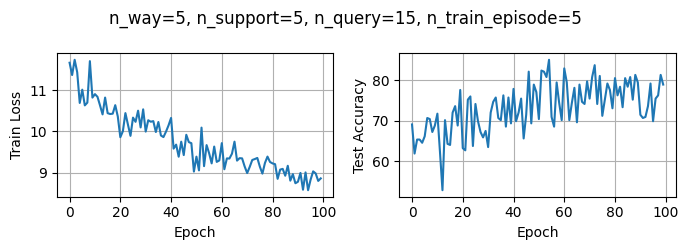

In [55]:
train_model(**parameters)